# Домашнее задание. Сегментация изображений

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>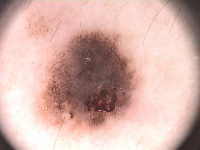</td><td>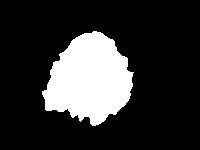</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'C:/Users/vitg1/PH2Dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [4]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [5]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [6]:
from torch.utils.data import DataLoader
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

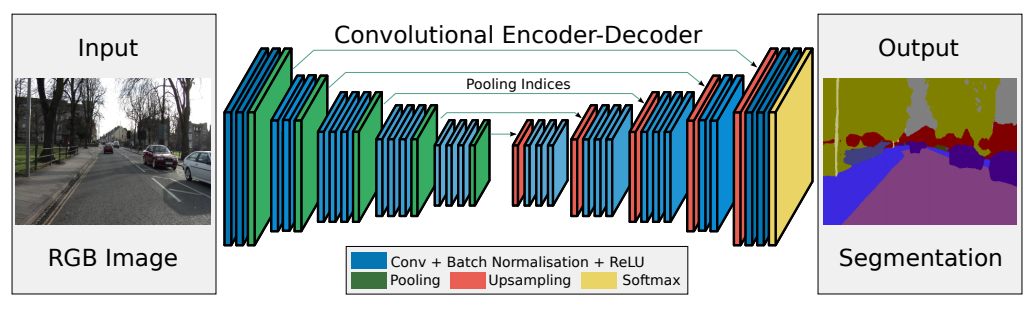

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim
from time import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

from collections import OrderedDict
import seaborn as sns

In [9]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # bottleneck
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),  
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),    
        )

        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),  
        )

        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
        )

        self.dec_conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)
        e4 = self.enc_conv4(e3)

        # decoder
        d0 = self.dec_conv0(e4)
        d1 = self.dec_conv1(d0+e3)
        d2 = self.dec_conv2(d1+e2)
        d3 = self.dec_conv3(d2+e1)
        d4 = self.dec_conv4(d3+e0)

        return d4

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [10]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    return thresholded

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [11]:
def bce_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    return torch.mean(y_pred - torch.mul(y_pred, y_real) + torch.log(1 + torch.exp(-y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [12]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    X_val, Y_val = next(iter(data_val))
    train_loss = []
    val_loss = []
    iou_score = []
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass 
            loss.backward()  # backward-pass
            opt.step()  # update weights
            avg_loss += loss / len(data_tr)

        train_loss.append(avg_loss.item())
        toc = time()
        print('loss train: %f' % avg_loss)

        if scheduler is not None:
            scheduler.step(avg_loss)
            #print(opt.param_groups[0]['lr'])

        # show intermediate results
        model.eval()  # testing mode
        X_val, Y_val = X_val.to(device), Y_val.to(device)
        Y_hat = model(X_val)
        loss = loss_fn(Y_val, Y_hat)
        Y_hat = torch.sigmoid(Y_hat)
        val_loss.append(loss.item()/len(data_val))

        iou = score_model(model, iou_pytorch, data_val)
        iou_score.append(iou)

        print('loss valid: %f' % val_loss[-1])

        # сохраняем веса лучшей модели
        if val_loss[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss[-1]))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = val_loss[-1]

        Y_hat, X_val, Y_val = Y_hat.detach().to('cpu'), X_val.to('cpu'), Y_val.to('cpu')
        
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    
    # загружаем модель с лучшими весами
    model.load_state_dict(torch.load('model.pt'))
    print('loading best model state')

    # выводим график обучения
    plt.plot(range(epochs), val_loss)
    plt.title('val_loss')
    plt.show()

    plt.plot(range(epochs), train_loss)
    plt.title('train_loss')
    plt.show()

    return val_loss, train_loss, iou_score

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [13]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [14]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            Y_pred = model(X_batch)
            #Y_pred = (Y_pred >= 0.5)
            Y_pred = (torch.sigmoid(Y_pred) >= 0.5)
            scores += metric(Y_pred, Y_label).mean().item()
    return scores/len(data)

## Обучение SegNet с  BCE_loss

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


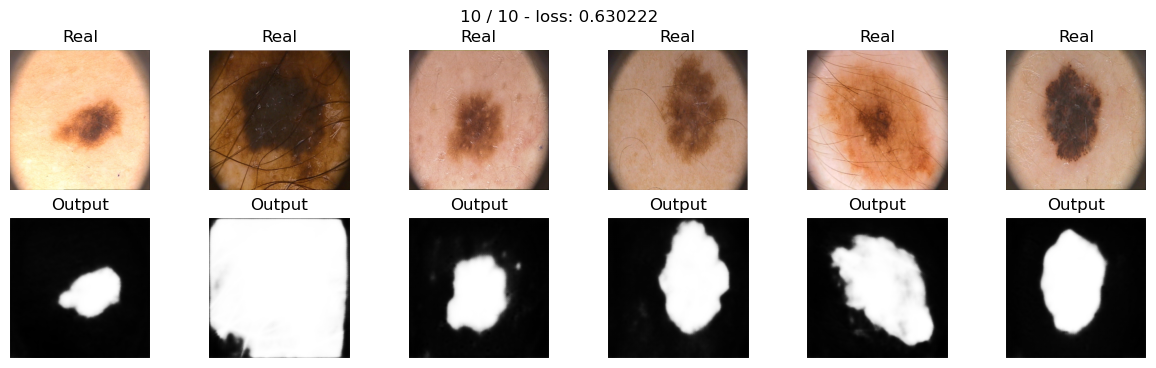

loading best model state


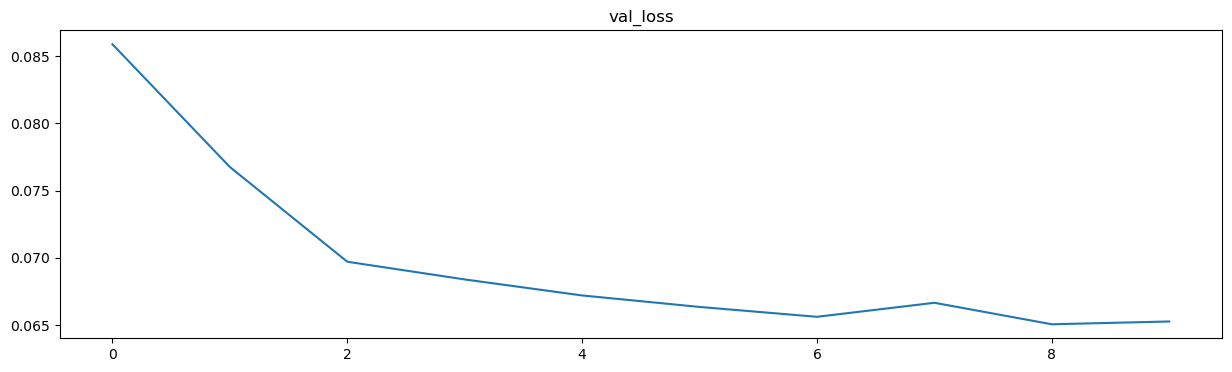

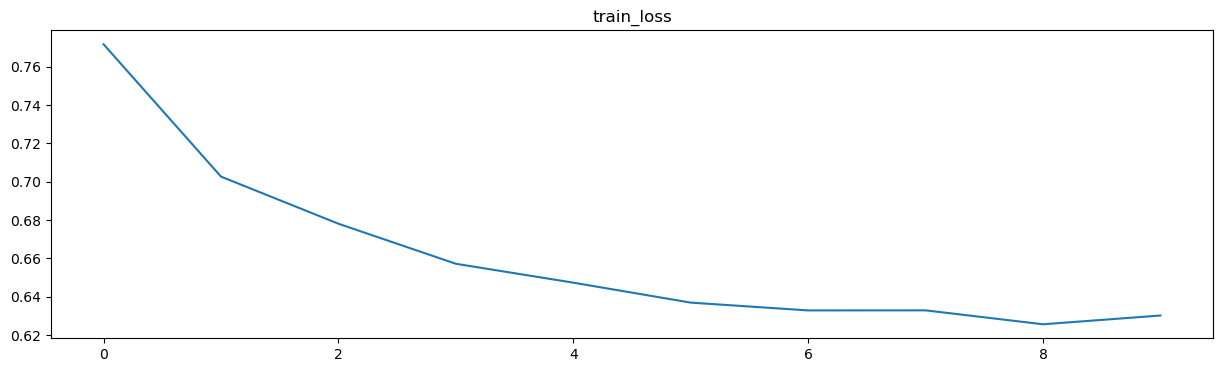

In [15]:
model = SegNet().to(device)
max_epochs = 10
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    patience=3,
    threshold=1e-4,
    mode="min"
)
results = train(model, optim, bce_loss, max_epochs, data_tr, data_val, scheduler)

## Дополнительная функция потерь: Dice loss

In [16]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred[:, 0].contiguous().view(-1)
    y_true = y_true[:, 0].contiguous().view(-1)
    intersection = (y_pred * y_true).sum()
    dsc = (2. * intersection + smooth) / (
        y_pred.sum() + y_true.sum() + smooth
    )
    return 1. - dsc

## Дополнительная функция потерь: Focal loss
[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [17]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred) + eps
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    focal_loss = -((1 - y_pred) ** gamma * y_real * y_pred.log() + (1-y_real)*(1-y_pred).log())
    return focal_loss.mean()

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

#### Dice BCE Loss

In [18]:
def dice_bce_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = bce_loss(y_true, y_pred)
    return bce + dice

#### Tversky loss

In [19]:
def tverskyloss(targets, inputs):
    smooth = 1
    alpha = 0.5
    beta = 0.5
    inputs = torch.sigmoid(inputs)
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    intersection = (inputs * targets).sum()
    FP = ((1-targets) * inputs).sum()
    FN = (targets * (1-inputs)).sum()
    
    Tversky = (intersection + smooth) / (intersection + alpha*FP + beta*FN + smooth)  
    
    return 1 - Tversky

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

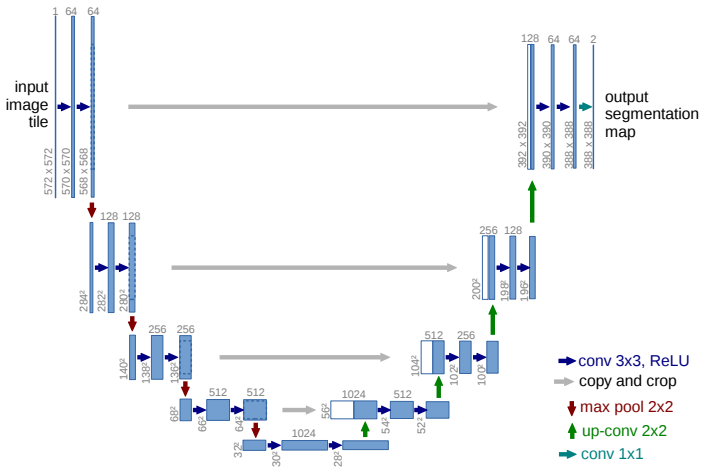

### Unet v1

In [20]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )   

class Unet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)      

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(512 + 1024, 512)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 1, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)
        
        conv5 = self.dconv_down5(x)

        x = torch.cat([x, conv5], dim=1)
        x = self.upsample(x)  
        x = self.dconv_up4(x)


        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

### Unet v2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [21]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(inplace=True)
    )  

class Unet2(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)      

        self.maxpool = nn.MaxPool2d(2)
        self.upsample4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dconv_up4 = double_conv(512 + 1024, 512)

        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv_up3 = double_conv(256 + 512, 256)

        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv_up2 = double_conv(128 + 256, 128)

        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.conv_last = nn.Conv2d(64, 1, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)  

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        conv5 = self.dconv_down5(x)
        x = self.maxpool(conv5)

        x = self.upsample4(x)
        x = torch.cat((x, conv5), dim=1)
        x = self.dconv_up4(x)
        
        x = self.upsample3(x)
        x = torch.cat((x, conv4), dim=1)
        x = self.dconv_up3(x)

        x = self.upsample2(x)
        x = torch.cat((x, conv3), dim=1)
        x = self.dconv_up2(x)

        x = self.upsample1(x)
        x = torch.cat((x, conv2), dim=1)   
        x = self.dconv_up1(x)
        
        x = self.upsample0(x)
        out = self.conv_last(x)
        
        return out

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [22]:
import pandas as pd

In [23]:
tesing_results = pd.DataFrame(columns=['model', 'loss', 'val_loss_score', 'iou_test_score'])

In [24]:
max_epochs = 20

In [25]:
def testing_models(model, epochs, loss, data_tr, data_val, data_ts, loss_name, model_name):
    global tesing_results
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=5,
        threshold=1e-4,
        mode="min"
        )
    
    val_loss, _, iou_valid_scores = train(model, optimizer, loss, epochs, data_tr, data_val, scheduler)
    iou_test_score = score_model(model, iou_pytorch, data_ts)

    tesing_results = tesing_results.append(
        pd.Series([
               model_name,
               loss_name,
               np.mean(val_loss),
               iou_test_score],
              index=tesing_results.columns),
              ignore_index=True)
    return val_loss, iou_valid_scores

### Тестируем Segnet

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# segnet with bce loss
model_segnet_bce = SegNet().to(device)

segnet_bce_val_loss, segnet_bce_iou_valid_scores = testing_models(
    model_segnet_bce,
    max_epochs,
    bce_loss,
    data_tr,
    data_val,
    data_ts,
    'bce_loss',
    'segnet',
    )

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# segnet with dice loss
model_segnet_dice = SegNet().to(device)

segnet_dice_val_loss, segnet_dice_iou_valid_scores = testing_models(
    model_segnet_dice,
    max_epochs,
    dice_loss,
    data_tr,
    data_val,
    data_ts,
    'dice_loss',
    'segnet',
    )

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# segnet with focal loss
model_segnet_focal = SegNet().to(device)

segnet_focal_val_loss, segnet_focal_iou_valid_scores = testing_models(
    model_segnet_focal,
    max_epochs,
    focal_loss,
    data_tr,
    data_val,
    data_ts,
    'focal_loss',
    'segnet',
    )

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# segnet with tversky loss
model_segnet_tversky = SegNet().to(device)

segnet_tversky_val_loss, segnet_tversky_iou_valid_scores = testing_models(
    model_segnet_tversky,
    max_epochs,
    tverskyloss,
    data_tr,
    data_val,
    data_ts,
    'tversky_loss',
    'segnet',
    )

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("iou metrics of segnet model")
plt.plot(range(max_epochs), segnet_tversky_iou_valid_scores, label="Segnet with Tversky loss", linewidth=2)
plt.plot(range(max_epochs), segnet_dice_iou_valid_scores, label="Segnet with Dice loss", linewidth=2)
plt.plot(range(max_epochs), segnet_bce_iou_valid_scores, label="Segnet with BCE loss", linewidth=2)
plt.plot(range(max_epochs), segnet_focal_iou_valid_scores, label="Segnet with Focal loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
tesing_results

### Тестируем Unet v1

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# Unet v1 with BCE loss
model_unet1_bce = Unet().to(device)

unet1_bce_val_loss, unet1_bce_iou_valid_scores = testing_models(
    model_unet1_bce,
    max_epochs,
    bce_loss,
    data_tr,
    data_val,
    data_ts,
    'bce_loss',
    'unet1'
    )

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# Unet v1 with Dice loss
model_unet1_dice = Unet().to(device)

unet1_dice_val_loss, unet1_dice_iou_valid_scores = testing_models(
    model_unet1_dice,
    max_epochs,
    dice_loss,
    data_tr,
    data_val,
    data_ts,
    'dice_loss',
    'unet1'
    )

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# Unet v1 with Focal loss
model_unet1_focal = Unet().to(device)

unet1_focal_val_loss, unet1_focal_iou_valid_scores = testing_models(
    model_unet1_focal,
    max_epochs,
    focal_loss,
    data_tr,
    data_val,
    data_ts,
    'focal_loss',
    'unet1'
    )

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# Unet v1 with Tversky loss
model_unet1_tversky = Unet().to(device)

unet1_tversky_val_loss, unet1_tversky_iou_valid_scores = testing_models(
    model_unet1_tversky,
    max_epochs,
    tverskyloss,
    data_tr,
    data_val,
    data_ts,
    'tversky_loss',
    'unet1'
    )

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("iou metrics of unet v1 model")
plt.plot(range(max_epochs), unet1_tversky_iou_valid_scores, label="Unet with Tversky loss", linewidth=2)
plt.plot(range(max_epochs), unet1_dice_iou_valid_scores, label="Unet with Dice loss", linewidth=2)
plt.plot(range(max_epochs), unet1_bce_iou_valid_scores, label="Unet with BCE loss", linewidth=2)
plt.plot(range(max_epochs), unet1_focal_iou_valid_scores, label="Unet with Focal loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
tesing_results

### Тестируем Unet v2

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# Unet v2 with BCE loss
model_unet2_bce = Unet2().to(device)

unet2_bce_val_loss, unet2_bce_iou_valid_scores = testing_models(
    model_unet2_bce,
    max_epochs,
    bce_loss,
    data_tr,
    data_val,
    data_ts,
    'bce_loss',
    'unet2'
    )

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# Unet v2 with Dice loss
model_unet2_dice = Unet2().to(device)

unet2_dice_val_loss, unet2_dice_iou_valid_scores = testing_models(
    model_unet2_dice,
    max_epochs,
    dice_loss,
    data_tr,
    data_val,
    data_ts,
    'dice_loss',
    'unet2'
    )

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# Unet v2 with Focal loss
model_unet2_focal = Unet2().to(device)

unet2_focal_val_loss, unet2_focal_iou_valid_scores = testing_models(
    model_unet2_focal,
    max_epochs,
    focal_loss,
    data_tr,
    data_val,
    data_ts,
    'focal_loss',
    'unet2'
    )

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# Unet v2 with Focal loss
model_unet2_tversky = Unet2().to(device)

unet2_tversky_val_loss, unet2_tversky_iou_valid_scores = testing_models(
    model_unet2_tversky,
    max_epochs,
    tverskyloss,
    data_tr,
    data_val,
    data_ts,
    'tversky_loss',
    'unet2'
    )

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("iou metrics of unet v2 model")
plt.plot(range(max_epochs), unet2_tversky_iou_valid_scores, label="Unet with Tversky loss", linewidth=2)
plt.plot(range(max_epochs), unet2_dice_iou_valid_scores, label="Unet with Dice loss", linewidth=2)
plt.plot(range(max_epochs), unet2_bce_iou_valid_scores, label="Unet with BCE loss", linewidth=2)
plt.plot(range(max_epochs), unet2_focal_iou_valid_scores, label="Unet with Focal loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

###  Итоги:

In [ ]:
pd.pivot_table(tesing_results, values='iou_test_score', index=['model', 'loss'])